Magic: the Gathering (Magic) is the most successful and enduring trading card game in existence. It was introduced in 1993 and new cards are introduced around every three months if not more often. In 2018, the online platform Magic Arena purportedly made over $10 million in digital gaming revenue. The 2020 sets have seen "double digit growth" according to a conference call by Hasbro CEO Brian Goldner.
 
In looking at the various collectible card games (CCGs) that have been released since Magic, many, if not most, are no longer in print; this could be taken as a statement that it was no longer viable to create new product or that the creators had completed what they set out to do. This begs the question: "Why is Magic still so popular?"
 
Mark Rosewater, current head of R&D for Magic, wrote in 2003 that "the color pie is the heart of the game." The color system was introduced in the first set, Alpha, and continues today. The five colors of Magic are white, blue, black, red, and green, with each color having a specialty, if you will. While describing exactly what each color can do is vast -- an article from 2017 shows primary, secondary, and tertiary mechanics for each color and each subgroup has several examples -- a summary from 2010 will suffice.
 
White mana comes from plains, meadows, and fields.
White magic brings light and order.
 
Blue mana comes from islands and bodies of water.
Blue magic involves intellect and illusion.
 
Black mana comes from swamps and places of death.
Black magic is steeped in darkness and death.
 
Red mana comes from the mountains and rocky places.
Red magic calls forth fire and passion.
 
Green mana comes from forests and jungles.
Green magic conjures growth and might.
 
“Green magic conjures growth and might” is the focus of this experiment. Specifically, the question to be answered is, “On average, are green creatures more powerful than creatures of other colors?” More precisely, the null hypothesis can be stated as, “The average green creature’s power is not higher than creatures of other colors.” Conversely, the alternative hypothesis can be stated as, “The average green creature’s power is higher than creatures of other colors.”
 
To answer this, a random sampling of cards of each color will be pulled from every card printed which can be found at https://mtgjson.com/api/v5/csv/cards.csv. This dataset contains over 50,000 cards spanning over 27 years with each row representing a card and containing a name, power, toughness, mana cost, as well as useful information. Once the random sampling has been acquired, A/A and A/B tests will be performed. If the data is normally distributed, t-tests will be performed. If the data is not normally distributed, Kruskal-Wallis tests will be performed.
 
Magic Arena boasts over 2.8 billion games played since its launch on September 27th, 2018 for an average of over 24 million games per week. If the color pie is the heart of the game, if it is incorrect, showing the fallacy of it could have a drastic effect on consumer confidence which could lead to decreased revenue, something the millions of players and the investors who have collectively invested millions of dollars don’t want to see.

In [1]:
#import the necessities
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import itertools
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
#call the data from the tab delimited txt file
mtg = pd.read_csv('D:/Downloads/cardsutf8.txt', sep='\t', header=0, low_memory=False)

In [3]:
#create the variables and sets that will be used later
white_creatures = pd.DataFrame()
blue_creatures = pd.DataFrame()
black_creatures = pd.DataFrame()
red_creatures = pd.DataFrame()
green_creatures = pd.DataFrame()

white_sample = pd.DataFrame()
blue_sample = pd.DataFrame()
black_sample = pd.DataFrame()
red_sample = pd.DataFrame()
green_sample = pd.DataFrame()

white_sample_2 = pd.DataFrame()
blue_sample_2 = pd.DataFrame()
black_sample_2 = pd.DataFrame()
red_sample_2 = pd.DataFrame()
green_sample_2 = pd.DataFrame()

In [4]:
## create the dataset of interest
#only black border cards are legal to play in
#magic so we'll remove the gold and silver
#bordered cards
filtered_mtg = mtg[mtg['borderColor'] == 'black']

#we're only interested in creatures so we'll
#drop any rows that aren't creatures
filtered_mtg_1 = filtered_mtg[filtered_mtg['types'].str.contains('Creature')]

#let's drop the duplicates
#for this experiment
filtered_mtg_2 = filtered_mtg_1.drop_duplicates(['name'])

#some of the values for power are not
#ints. because they are variable
#we'll drop the values
##after talking to my mentor, we determined
##a more elegant way to do this would be to
##use a lambda function to convert the cells
#with strings to null and then dropna
filtered_mtg_3 = filtered_mtg_2[(filtered_mtg_2['power'] != '*') & (filtered_mtg_2['power'] != '1+*') &
                               (filtered_mtg_2['power'] != '2+*') & (filtered_mtg_2['power'] != '?')]
filtered_mtg_3['power'] = filtered_mtg_3['power'].astype(int)

#let's get only the columns of interest
##while we're only interested in the power for
##this experiment, other factors may be analyzed
##in this or other experiments
dataset = filtered_mtg_3[['id', 'borderColor', 'colors', 'convertedManaCost', 'faceConvertedManaCost',
                          'faceName',  'manaCost', 'name', 'power','side', 'subtypes', 'supertypes', 'text', 
                          'toughness', 'type', 'types']]

#for this experiemt, we will focus only on
#the cards with a single color
#in future analyses, multi-color
#cards can also be analyzed
white_creatures = dataset[dataset['colors'] == 'W']
white_creatures.insert(0, 'unique_id', range(1, 1 + len(white_creatures)))
#we will continue this for each color
#second is blue
blue_creatures = dataset[dataset['colors'] == 'U']
blue_creatures.insert(0, 'unique_id', range(1, 1 + len(blue_creatures)))
#next black
black_creatures = dataset[dataset['colors'] == 'B']
black_creatures.insert(0, 'unique_id', range(1, 1 + len(black_creatures)))
#then red
red_creatures = dataset[dataset['colors'] == 'R']
red_creatures.insert(0, 'unique_id', range(1, 1 + len(red_creatures)))
#finishing the colors is green
green_creatures = dataset[dataset['colors'] == 'G']
green_creatures.insert(0, 'unique_id', range(1, 1 + len(green_creatures)))

In [5]:
#creating a random sampling from each color
##I attempted a power analysis to see what
##n I should use. I couldn't determine a 
##proper value to use so I chose a value
##of about 25%.
random_set = []
for item in range(400):
    #create random number here
    num = random.randint(1, white_creatures.shape[0])
    #check to see if that number has been selected before or not
    #if it has been selected, pick another random number
    while num in random_set:
        num = random.randint(1, white_creatures.shape[0])
    #if it hasn't, add it to the list and add the corresponding
    #creature information to the statistical sampling set
    random_set.append(num)
    white_sample = white_sample.append(white_creatures[white_creatures['unique_id'] == num])
#repeating the process below
#I would love to put these into for loops
#but am unable to use multiple variables
#with dataframes at present
random_set = []
for item in range(400):
    num = random.randint(1, blue_creatures.shape[0])
    while num in random_set:
        num = random.randint(1, blue_creatures.shape[0])
    random_set.append(num)
    blue_sample = blue_sample.append(blue_creatures[blue_creatures['unique_id'] == num])
random_set = []
for item in range(400):
    num = random.randint(1, black_creatures.shape[0])
    while num in random_set:
        num = random.randint(1, black_creatures.shape[0])
    random_set.append(num)
    black_sample = black_sample.append(black_creatures[black_creatures['unique_id'] == num])
random_set = []
for item in range(400):
    #create random number here
    num = random.randint(1, red_creatures.shape[0])
    #check to see if that number has been selected before or not
    while num in random_set:
        num = random.randint(1, red_creatures.shape[0])
    random_set.append(num)
    red_sample = red_sample.append(red_creatures[red_creatures['unique_id'] == num])
random_set = []
for item in range(400):
    #create random number here
    num = random.randint(1, green_creatures.shape[0])
    #check to see if that number has been selected before or not
    while num in random_set:
        num = random.randint(1, green_creatures.shape[0])
    random_set.append(num)
    green_sample = green_sample.append(green_creatures[green_creatures['unique_id'] == num])
#running the test again to allow for A/A analysis
#creating a random sampling from each color
random_set = []
for item in range(400):
    num = random.randint(1, white_creatures.shape[0])
    while num in random_set:
        num = random.randint(1, white_creatures.shape[0])
    random_set.append(num)
    white_sample_2 = white_sample_2.append(white_creatures[white_creatures['unique_id'] == num])
random_set = []
for item in range(400):
    num = random.randint(1, blue_creatures.shape[0])
    while num in random_set:
        num = random.randint(1, blue_creatures.shape[0])
    random_set.append(num)
    blue_sample_2 = blue_sample_2.append(blue_creatures[blue_creatures['unique_id'] == num])
random_set = []
for item in range(400):
    num = random.randint(1, black_creatures.shape[0])
    while num in random_set:
        num = random.randint(1, black_creatures.shape[0])
    random_set.append(num)
    black_sample_2 = black_sample_2.append(black_creatures[black_creatures['unique_id'] == num])
random_set = []
for item in range(400):
    #create random number here
    num = random.randint(1, red_creatures.shape[0])
    #check to see if that number has been selected before or not
    while num in random_set:
        num = random.randint(1, red_creatures.shape[0])
    random_set.append(num)
    red_sample_2 = red_sample_2.append(red_creatures[red_creatures['unique_id'] == num])
random_set = []
for item in range(400):
    #create random number here
    num = random.randint(1, green_creatures.shape[0])
    #check to see if that number has been selected before or not
    while num in random_set:
        num = random.randint(1, green_creatures.shape[0])
    random_set.append(num)
    green_sample_2 = green_sample_2.append(green_creatures[green_creatures['unique_id'] == num])

In [6]:
#getting the information from each power
print('The statistics for the first sampling of White creatures are')
print(white_sample['power'].describe())
print('\nThe statistics for the second sampling of White creatures are')
print(white_sample_2['power'].describe())
print('\n\nThe statistics for the first sampling of Blue creatures are')
print(blue_sample['power'].describe())
print('\nThe statistics for the second sampling of Blue creatures are')
print(blue_sample_2['power'].describe())
print('\n\nThe statistics for the first sampling of Black creatures are')
print(black_sample['power'].describe())
print('\nThe statistics for the second sampling of Black creatures are')
print(black_sample_2['power'].describe())
print('\n\nThe statistics for the first sampling of Red creatures are')
print(red_sample['power'].describe())
print('\nThe statistics for the second sampling of Red creatures are')
print(red_sample_2['power'].describe())
print('\n\nThe statistics for the first sampling of Green creatures are')
print(green_sample['power'].describe())
print('\nThe statistics for the second sampling of Green creatures are')
print(green_sample_2['power'].describe())

The statistics for the first sampling of White creatures are
count    400.000000
mean       2.150000
std        1.058443
min        0.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        6.000000
Name: power, dtype: float64

 The statistics for the second sampling of White creatures are
count    400.000000
mean       2.100000
std        1.280273
min        0.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        8.000000
Name: power, dtype: float64

 
The statistics for the first sampling of Blue creatures are
count    400.00000
mean       2.39000
std        1.62311
min        0.00000
25%        1.00000
50%        2.00000
75%        3.00000
max       11.00000
Name: power, dtype: float64

 The statistics for the second sampling of Blue creatures are
count    400.000000
mean       2.450000
std        1.853669
min        0.000000
25%        1.000000
50%        2.000000
75%        3.000000
max       13.000000
Name: power, dtype: float64

 
Th

White Creatures : Sample 1


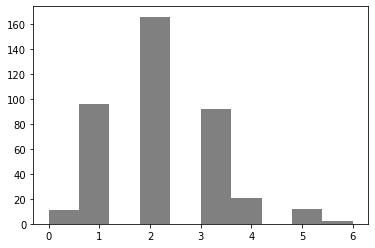


White Creatures : Sample 2


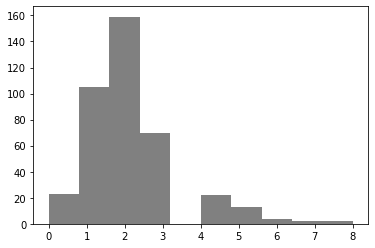


 
 Blue Creatures : Sample 1


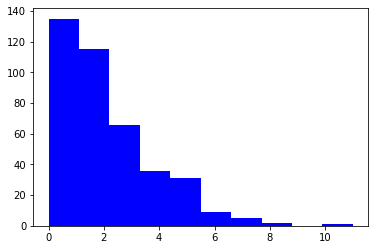


 Blue Creatures : Sample 2


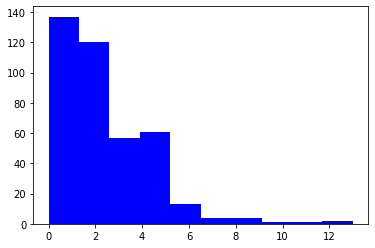


 
 Black Creatures : Sample 1


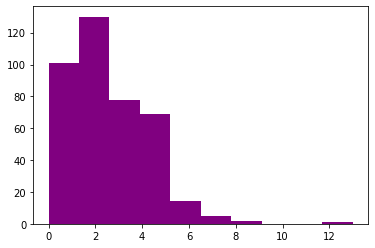


 Black Creatures : Sample 2


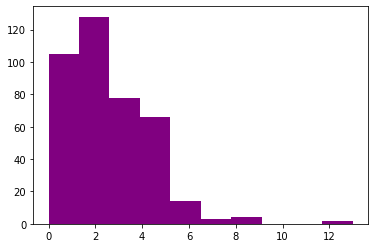


 
 Red Creatures : Sample 1


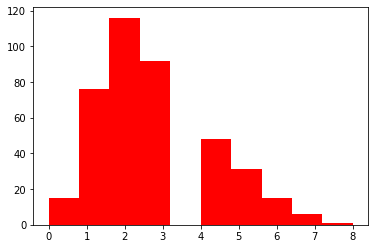


 Red Creatures : Sample 2


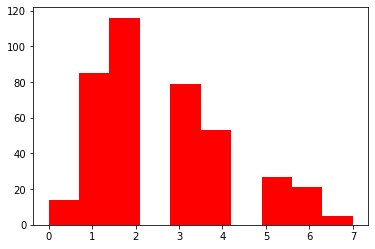


 
 Green Creatures : Sample 1


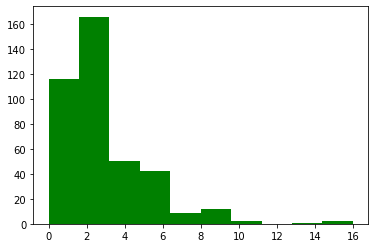


 Green Creatures : Sample 2


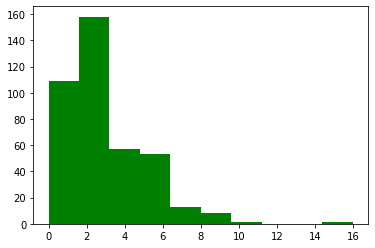

In [10]:
#create histograms for all five colors for sample 1 and sample 2
print('White Creatures : Sample 1')
plt.hist(white_sample['power'], color='gray')
plt.show()
print('\nWhite Creatures : Sample 2')
plt.hist(white_sample_2['power'], color='gray')
plt.show()
print('\n\nBlue Creatures : Sample 1')
plt.hist(blue_sample['power'], color='blue')
plt.show()
print('\nBlue Creatures : Sample 2')
plt.hist(blue_sample_2['power'], color='blue')
plt.show()
print('\n\nBlack Creatures : Sample 1')
plt.hist(black_sample['power'], color='purple')
plt.show()
print('\nBlack Creatures : Sample 2')
plt.hist(black_sample_2['power'], color='purple')
plt.show()
print('\n\nRed Creatures : Sample 1')
plt.hist(red_sample['power'], color='red')
plt.show()
print('\nRed Creatures : Sample 2')
plt.hist(red_sample_2['power'], color='red')
plt.show()
print('\n\nGreen Creatures : Sample 1')
plt.hist(green_sample['power'], color='green')
plt.show()
print('\nGreen Creatures : Sample 2')
plt.hist(green_sample_2['power'], color='green')
plt.show()

In [12]:
#since the data is not normal, we'll run
#kurskal-wallis tests. First, let's run them
#on samples 1 and 2 and then green against the
#other colors.
print('A/A Test on White Creatures')
print(stats.kruskal(white_sample['power'], white_sample_2['power']))
print('\nA/A Test on Blue Creatures')
print(stats.kruskal(blue_sample['power'], blue_sample_2['power']))
print('\nA/A Test on Black Creatures')
print(stats.kruskal(black_sample['power'], black_sample_2['power']))
print('\nA/A Test on Red Creatures')
print(stats.kruskal(red_sample['power'], red_sample_2['power']))
print('\nA/A Test on Green Creatures')
print(stats.kruskal(green_sample['power'], green_sample_2['power']))

A/A Test on White Creatures
KruskalResult(statistic=2.1670269997893734, pvalue=0.1409985902261528)

 A/A Test on Blue Creatures
KruskalResult(statistic=0.01989654503706883, pvalue=0.8878264032823051)

 A/A Test on Black Creatures
KruskalResult(statistic=0.08702869692959848, pvalue=0.7679890931088177)

 A/A Test on Red Creatures
KruskalResult(statistic=0.12672818058090637, pvalue=0.7218487899124728)

 A/A Test on Green Creatures
KruskalResult(statistic=0.5527058242887275, pvalue=0.457214198708477)


In [13]:
#all of these have p values > 0.05 and only
#white has a value of statistical significance.
#since we fail to reject the null that there's 
#a meaningful difference in our A/A tests
#we'll run kw tests on green vs other colors
print('A/B Test on Green Creatures vs White Creatures')
print(stats.kruskal(green_sample['power'], white_sample['power']))
print('\nA/B Test on Green Creatures vs Blue Creatures')
print(stats.kruskal(green_sample['power'], blue_sample['power']))
print('\nA/B Test on Green Creatures vs Black Creatures')
print(stats.kruskal(green_sample['power'], black_sample['power']))
print('\nA/B Test on Green Creatures vs Red Creatures')
print(stats.kruskal(green_sample['power'], red_sample['power']))

A/B Test on Green Creatures vs White Creatures
KruskalResult(statistic=11.146198659877848, pvalue=0.0008420404547964691)

A/B Test on Green Creatures vs Blue Creatures
KruskalResult(statistic=5.993441419184248, pvalue=0.014359161837701905)

A/B Test on Green Creatures vs Black Creatures
KruskalResult(statistic=0.17601445483430636, pvalue=0.6748209676827488)

A/B Test on Green Creatures vs Red Creatures
KruskalResult(statistic=0.3552657550405595, pvalue=0.5511473432942993)


In [ ]:
#we can reject the null between white/blue
#and green creatures but fail to reject
#the null for red and black.

Since we failed to reject to null on half comparisons, we can state safely that there is no meaningful statistical difference between Green and the other colors. Does this mean Wizards is wrong or is misleading their customers and investors? Well, maybe, but probably not. It's likely there are a couple more areas to consider, like bias and other factors.

The first item to discuss is bias. There is a large confirmation bias when the player consistently sees cards like Kazandu Stomper and Sneaking Guide (https://gatherer.wizards.com/Pages/Card/Details.aspx?multiverseid=491838 and https://gatherer.wizards.com/Pages/Card/Details.aspx?multiverseid=491772 respectively) and sees that 6 is significantly bigger than 0 and doesn't think about the cards like Tajuru Blightblade and Pyroclastic Hellion (https://gatherer.wizards.com/Pages/Card/Details.aspx?multiverseid=491856 and https://gatherer.wizards.com/Pages/Card/Details.aspx?multiverseid=491793 respectively) to see that 1 is smaller than 4.

A second item to investigate is the other factors of the card. We set aside the many other factors of the cards, such as converted mana cost, toughness, rarity, number of times reprinted, etc, to compare power in this experiment. If we were to include these parameters, we might find that Green creatures have higher power relative to their converted mana cost or that Green creatures have a higher power and toughness than the other colors. These could be investigated more in further experiments.